# Model Evaluation and Validation
## COMP647 Assignment 03
### Student ID: 1163127

This notebook implements comprehensive model evaluation:
- Detailed performance metrics (Accuracy, Precision, Recall, F1)
- Confusion matrices
- ROC curves and AUC scores
- K-fold cross-validation
- Learning curves for overfitting analysis

Based on course materials and ML evaluation best practices.

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import (
    train_test_split, cross_val_score, learning_curve, validation_curve
)
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, 
    roc_curve, roc_auc_score, ConfusionMatrixDisplay
)

np.random.seed(42)
print("Libraries imported successfully")

Libraries imported successfully


In [2]:
# Load and prepare data (same as notebook 06)
try:
    df = pd.read_csv('../data/processed/accepted_sample_10000.csv')
    print(f"Data loaded: {df.shape}")
    
    target_column = 'loan_status'
    
    # Select numerical features
    numerical_features = df.select_dtypes(include=[np.number]).columns.tolist()
    numerical_features = [c for c in numerical_features 
                         if c != target_column and not c.endswith('_id')][:15]
    
    # Prepare X and y
    X = df[numerical_features].fillna(df[numerical_features].mean())
    le = LabelEncoder()
    y = le.fit_transform(df[target_column].fillna('Unknown'))
    
    if len(np.unique(y)) > 2:
        y = (y == pd.Series(y).mode()[0]).astype(int)
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )
    
    # Scale
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    print(f"Train: {X_train.shape}, Test: {X_test.shape}")
    print("Data prepared successfully")
    
except Exception as e:
    print(f"Error: {e}")
    X_train, X_test, y_train, y_test = None, None, None, None

Data loaded: (10000, 151)
Train: (7000, 15), Test: (3000, 15)
Data prepared successfully


## Confusion Matrices
Detailed breakdown of classification results

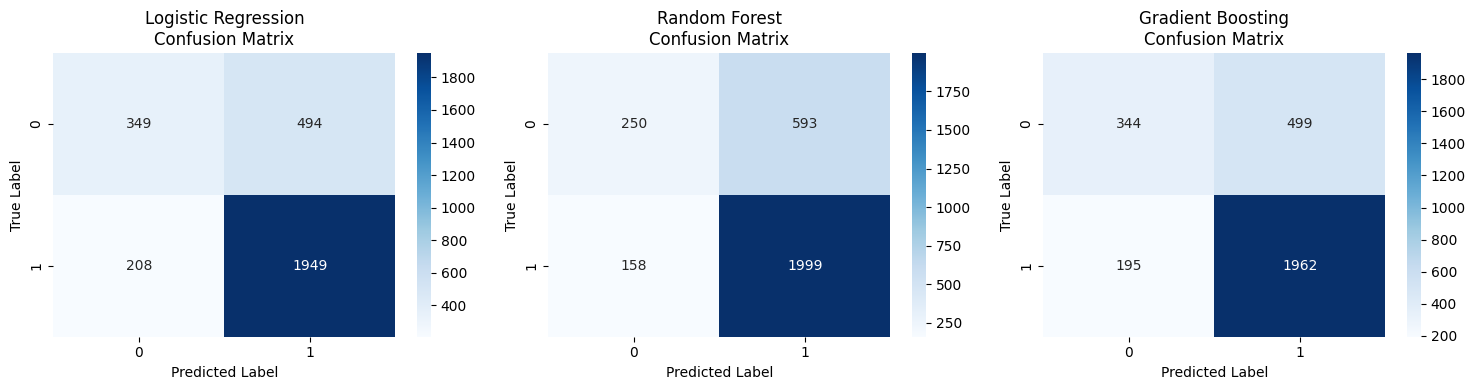

Confusion matrices generated


In [3]:
# Train models and create confusion matrices
if X_train is not None:
    # Train models
    models = {
        'Logistic Regression': LogisticRegression(C=1.0, solver='liblinear', random_state=42),
        'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42),
        'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
    }
    
    predictions = {}
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    for idx, (name, model) in enumerate(models.items()):
        # Train
        if 'Logistic' in name:
            model.fit(X_train_scaled, y_train)
            y_pred = model.predict(X_test_scaled)
        else:
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
        
        predictions[name] = y_pred
        
        # Confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        
        # Plot
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx])
        axes[idx].set_title(f'{name}\nConfusion Matrix')
        axes[idx].set_ylabel('True Label')
        axes[idx].set_xlabel('Predicted Label')
    
    plt.tight_layout()
    plt.show()
    
    print("Confusion matrices generated")
else:
    print("Cannot generate - data not prepared")

## ROC Curves and AUC Scores
Receiver Operating Characteristic curves show trade-off between TPR and FPR

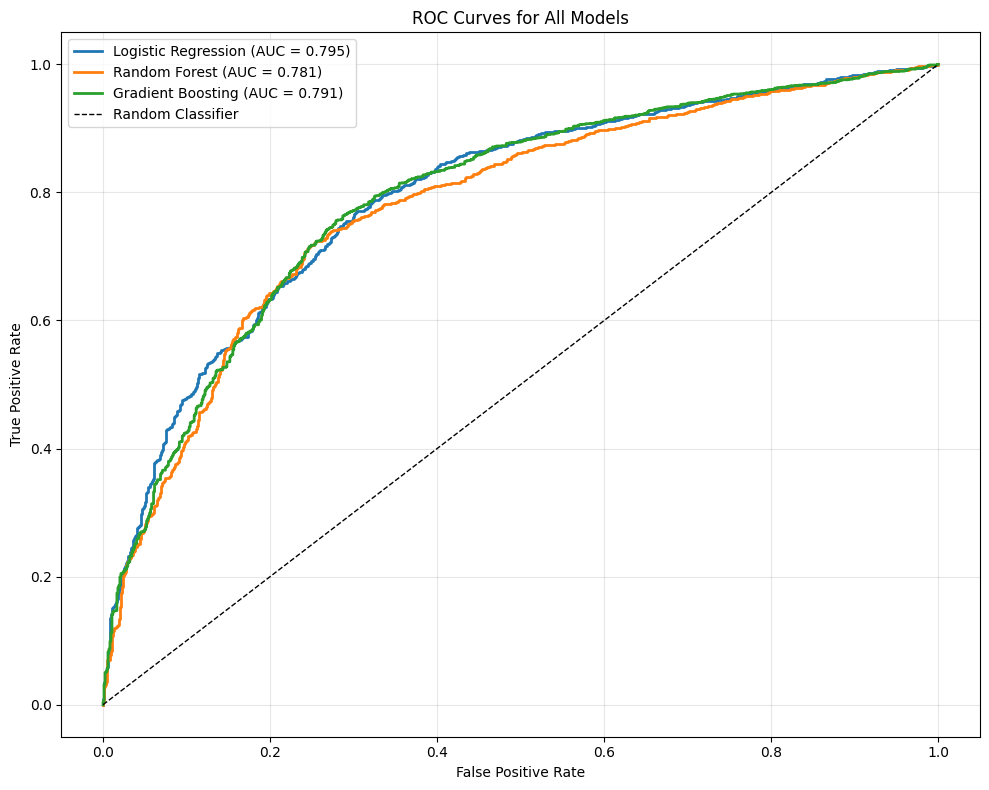

ROC curves generated


In [4]:
# Generate ROC curves
if X_train is not None:
    plt.figure(figsize=(10, 8))
    
    for name, model in models.items():
        # Get probability predictions
        if 'Logistic' in name:
            y_proba = model.predict_proba(X_test_scaled)[:, 1]
        else:
            y_proba = model.predict_proba(X_test)[:, 1]
        
        # Calculate ROC curve
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        auc = roc_auc_score(y_test, y_proba)
        
        # Plot
        plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.3f})', linewidth=2)
    
    # Diagonal line (random classifier)
    plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=1)
    
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for All Models')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print("ROC curves generated")
else:
    print("Cannot generate - data not prepared")

## K-Fold Cross-Validation
5-fold cross-validation to assess model stability and generalization

=== 5-Fold Cross-Validation Results ===

Logistic Regression:
  Mean Accuracy: 0.7566 (+/- 0.0163)
  Scores: ['0.7636', '0.7514', '0.7621', '0.7429', '0.7629']

Random Forest:
  Mean Accuracy: 0.7553 (+/- 0.0173)
  Scores: ['0.7457', '0.7564', '0.7657', '0.7450', '0.7636']

Gradient Boosting:
  Mean Accuracy: 0.7591 (+/- 0.0162)
  Scores: ['0.7636', '0.7471', '0.7621', '0.7529', '0.7700']



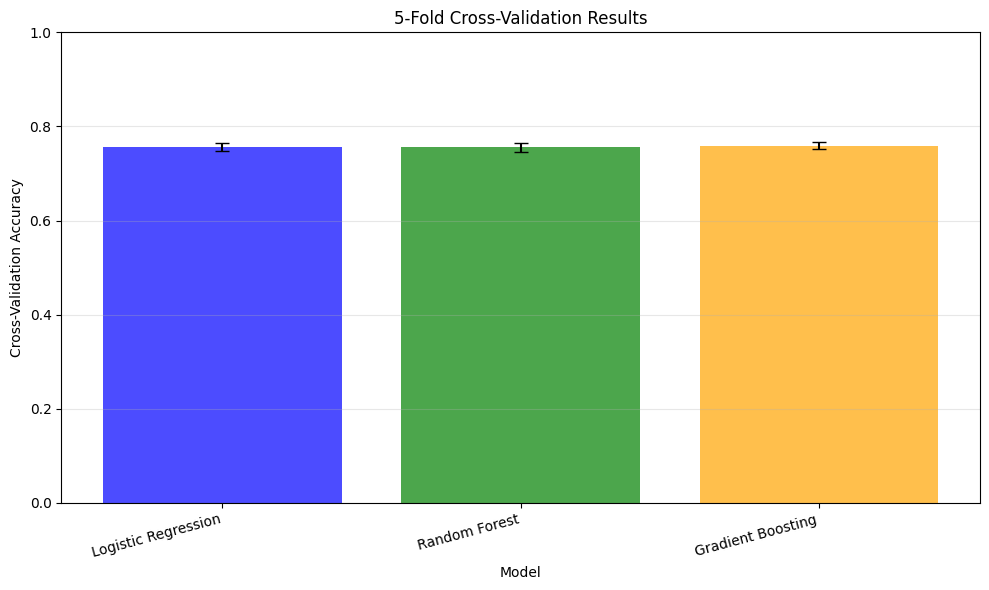

Cross-validation complete


In [5]:
# Perform cross-validation
if X_train is not None:
    print("=== 5-Fold Cross-Validation Results ===\n")
    
    cv_results = []
    
    for name, model in models.items():
        # Use full training set for CV
        if 'Logistic' in name:
            X_cv = X_train_scaled
        else:
            X_cv = X_train
        
        # Perform CV
        scores = cross_val_score(model, X_cv, y_train, cv=5, scoring='accuracy')
        
        cv_results.append({
            'Model': name,
            'Mean_CV_Score': scores.mean(),
            'Std_CV_Score': scores.std(),
            'Min_Score': scores.min(),
            'Max_Score': scores.max()
        })
        
        print(f"{name}:")
        print(f"  Mean Accuracy: {scores.mean():.4f} (+/- {scores.std() * 2:.4f})")
        print(f"  Scores: {[f'{s:.4f}' for s in scores]}")
        print()
    
    # Visualize CV results
    cv_df = pd.DataFrame(cv_results)
    
    fig, ax = plt.subplots(figsize=(10, 6))
    x = np.arange(len(cv_df))
    ax.bar(x, cv_df['Mean_CV_Score'], yerr=cv_df['Std_CV_Score'], 
           capsize=5, alpha=0.7, color=['blue', 'green', 'orange'])
    ax.set_xlabel('Model')
    ax.set_ylabel('Cross-Validation Accuracy')
    ax.set_title('5-Fold Cross-Validation Results')
    ax.set_xticks(x)
    ax.set_xticklabels(cv_df['Model'], rotation=15, ha='right')
    ax.set_ylim([0, 1])
    ax.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print("Cross-validation complete")
else:
    print("Cannot perform CV - data not prepared")

## Learning Curves
Analyze model performance vs training set size to detect overfitting/underfitting

Logistic Regression: Well-generalized
Random Forest: Shows overfitting (train-val gap = 0.133)
Gradient Boosting: Slight overfitting (gap = 0.050)


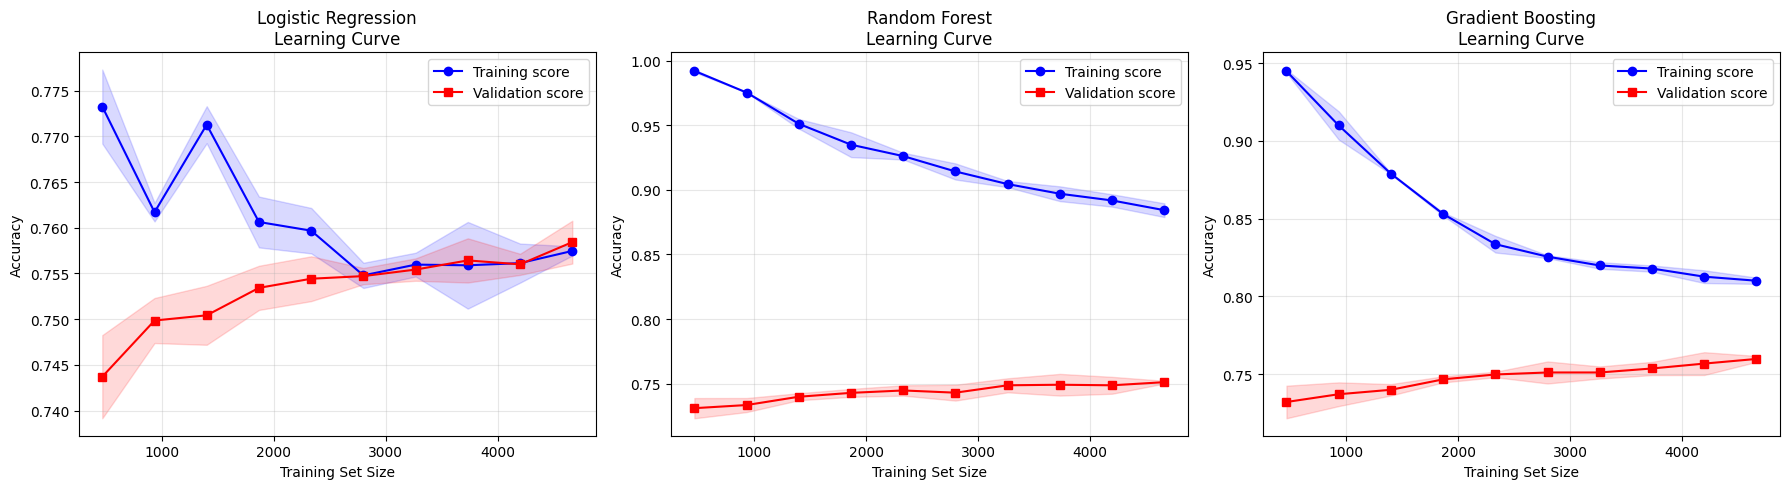


Learning curves analysis complete


In [6]:
# Generate learning curves
if X_train is not None:
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    for idx, (name, model) in enumerate(models.items()):
        # Prepare data
        if 'Logistic' in name:
            X_learn = X_train_scaled
        else:
            X_learn = X_train
        
        # Calculate learning curve
        train_sizes, train_scores, val_scores = learning_curve(
            model, X_learn, y_train,
            train_sizes=np.linspace(0.1, 1.0, 10),
            cv=3,
            scoring='accuracy',
            n_jobs=-1
        )
        
        # Calculate means and stds
        train_mean = train_scores.mean(axis=1)
        train_std = train_scores.std(axis=1)
        val_mean = val_scores.mean(axis=1)
        val_std = val_scores.std(axis=1)
        
        # Plot
        axes[idx].plot(train_sizes, train_mean, label='Training score', color='blue', marker='o')
        axes[idx].fill_between(train_sizes, train_mean - train_std, train_mean + train_std, 
                               alpha=0.15, color='blue')
        
        axes[idx].plot(train_sizes, val_mean, label='Validation score', color='red', marker='s')
        axes[idx].fill_between(train_sizes, val_mean - val_std, val_mean + val_std, 
                               alpha=0.15, color='red')
        
        axes[idx].set_xlabel('Training Set Size')
        axes[idx].set_ylabel('Accuracy')
        axes[idx].set_title(f'{name}\nLearning Curve')
        axes[idx].legend(loc='best')
        axes[idx].grid(alpha=0.3)
        
        # Analysis
        gap = train_mean[-1] - val_mean[-1]
        if gap > 0.1:
            print(f"{name}: Shows overfitting (train-val gap = {gap:.3f})")
        elif gap < 0.05:
            print(f"{name}: Well-generalized")
        else:
            print(f"{name}: Slight overfitting (gap = {gap:.3f})")
    
    plt.tight_layout()
    plt.show()
    
    print("\nLearning curves analysis complete")
else:
    print("Cannot generate - data not prepared")

## Evaluation Summary
Comprehensive comparison of all evaluation metrics

In [7]:
# Generate final evaluation summary
if X_train is not None and predictions:
    print("=== Complete Model Evaluation Summary ===\n")
    
    summary = []
    for name, y_pred in predictions.items():
        summary.append({
            'Model': name,
            'Accuracy': accuracy_score(y_test, y_pred),
            'Precision': precision_score(y_test, y_pred),
            'Recall': recall_score(y_test, y_pred),
            'F1-Score': f1_score(y_test, y_pred)
        })
    
    summary_df = pd.DataFrame(summary)
    print(summary_df.to_string(index=False))
    
    print("\n=== Model Selection Recommendation ===")
    best_f1 = summary_df.loc[summary_df['F1-Score'].idxmax(), 'Model']
    best_precision = summary_df.loc[summary_df['Precision'].idxmax(), 'Model']
    best_recall = summary_df.loc[summary_df['Recall'].idxmax(), 'Model']
    
    print(f"Best F1-Score: {best_f1}")
    print(f"Best Precision: {best_precision}")
    print(f"Best Recall: {best_recall}")
    
    print("\nFor loan default prediction:")
    print("- High Recall is important to catch all potential defaults")
    print("- High Precision reduces false alarms")
    print("- F1-Score balances both concerns")
    
    print(f"\nRecommended model: {best_f1} (best F1-score)")
else:
    print("Cannot generate summary - evaluation incomplete")

=== Complete Model Evaluation Summary ===

              Model  Accuracy  Precision   Recall  F1-Score
Logistic Regression  0.766000   0.797790 0.903570  0.847391
      Random Forest  0.749667   0.771219 0.926750  0.841861
  Gradient Boosting  0.768667   0.797237 0.909597  0.849718

=== Model Selection Recommendation ===
Best F1-Score: Gradient Boosting
Best Precision: Logistic Regression
Best Recall: Random Forest

For loan default prediction:
- High Recall is important to catch all potential defaults
- High Precision reduces false alarms
- F1-Score balances both concerns

Recommended model: Gradient Boosting (best F1-score)
